In [1]:
import copy
from functools import partial
import gc
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from uncertainty_testbed.generators.data_generator_explicit import AnalyticBinaryClassGenerator
from uncertainty_testbed.utilities.functions import map_to_constant
from uncertainty_testbed.uncertainty_models.mc_dropout import MCDropoutLayer, MCDropoutKerasClassification

2022-05-01 09:34:19.385136: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-01 09:34:19.385166: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# generate some data
s = partial(map_to_constant, c=0.3)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="cauchy", threshold=0.5,
                                  noise_distribution="cauchy", noise_scale=s)
x, y = eg.generate_labeled(120096)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:100096, :], y[:100096]
x_val, y_val = x[100096:, :], y[100096:]

In [3]:
def opt_name(optimizer):
    return str(optimizer).split("object")[0].split(".")[-1].strip().lower()

optimizer_lookup = {
    opt_name(opt): opt for opt in  
    [keras.optimizers.Nadam(learning_rate=3e-5), 
     keras.optimizers.SGD(learning_rate=5e-3), 
     keras.optimizers.RMSprop(learning_rate=5e-3),
     keras.optimizers.Adam(learning_rate=3e-3),
     keras.optimizers.Adadelta(learning_rate=1e-1),
     keras.optimizers.Adamax(learning_rate=7e-3)]
}

scan_schedule = [
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=3e-5),
        "learning_rate": 3e-5,
        "batch": 256,
        "epoch": 28
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 256,
        "epoch": 59
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=1e-2),
        "learning_rate" :1e-2,
        "batch": 8,
        "epoch": 1
    },
    {
        "optimizer": keras.optimizers.RMSprop(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 8,
        "epoch": 1# 0.1781
    },
    {
        "optimizer": keras.optimizers.Adam(learning_rate=3e-3),
        "learning_rate": 3e-3,
        "batch": 8,
        "epoch": 1# 0.2076
    },
    {
        "optimizer": keras.optimizers.Adadelta(learning_rate=1e-1),
        "learning_rate": 1e-1,
        "batch": 8,
        "epoch": 2# 0.2354
    },
    {
        "optimizer": keras.optimizers.Adamax(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 1# 0.2249
    },
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 4# 0.1905
    }
]

In [4]:
scan_results = []
champion_params = None
champion_loss = np.inf
for params in scan_schedule:
    lr = params["learning_rate"]
    for learning_rate in [0.8*lr, lr, 1.2*lr]:
        optimizer = params["optimizer"]
        optimizer.learning_rate.assign(learning_rate)
        num_epochs = int(1.4*params["epoch"] + 2)
        batch_size = int(params["batch"])
        model = keras.Sequential()
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(1, activation="sigmoid"))
        model.compile(
            optimizer=optimizer,
            loss="binary_crossentropy",
            metrics=["accuracy", "AUC"]
        )
        history = model.fit(
            x_train,
            y_train,
            epochs=num_epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
        )
        
        history_dict = history.history
        val_loss = history_dict["val_loss"]
        val_auc = history_dict["val_auc"]
        val_accuracy = history_dict["val_accuracy"]
        epochs = range(1, len(val_loss)+1)
        
        best_loss = {"loss": val_loss[np.argmin(val_loss)], "epoch": epochs[np.argmin(val_loss)]}
        best_auc = {"auc": val_auc[np.argmax(val_auc)], "epoch": epochs[np.argmax(val_auc)]}
        best_accuracy = {"accuracy": val_accuracy[np.argmax(val_accuracy)], "epoch": epochs[np.argmax(val_accuracy)]}
        
        ps = {k: copy.deepcopy(v) for k, v in params.items() if k not in ["optimizer", "model"]}
        ps["optimizer"] = opt_name(optimizer)
        ps["learning_rate"] = copy.deepcopy(learning_rate)
        ps["best_loss"] = best_loss
        ps["best_auc"] = best_auc
        ps["best_accuracy"] = best_accuracy
        print(ps)
        scan_results.append(ps)
        
        if best_loss["loss"] < champion_loss:
            champion_loss = best_loss["loss"]
            champion_params = {k: copy.deepcopy(v) for k, v in ps.items()}
            champion_params["model"] = keras.models.clone_model(model)
        

model = keras.models.clone_model(champion_params["model"])

2022-05-01 09:34:25.276912: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-01 09:34:25.276981: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-01 09:34:25.277009: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps): /proc/driver/nvidia/version does not exist
2022-05-01 09:34:25.277973: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/41
391/391 [==============================] - 3s 4ms/step - loss: 0.6965 - accuracy: 0.5178 - auc: 0.5229 - val_loss: 0.6856 - val_accuracy: 0.5748 - val_auc: 0.6035
Epoch 2/41
391/391 [==============================] - 1s 3ms/step - loss: 0.6907 - accuracy: 0.5323 - auc: 0.5460 - val_loss: 0.6792 - val_accuracy: 0.6187 - val_auc: 0.6649
Epoch 3/41
391/391 [==============================] - 1s 3ms/step - loss: 0.6843 - accuracy: 0.5534 - auc: 0.5753 - val_loss: 0.6711 - val_accuracy: 0.6541 - val_auc: 0.7129
Epoch 4/41
391/391 [==============================] - 1s 3ms/step - loss: 0.6774 - accuracy: 0.5715 - auc: 0.6013 - val_loss: 0.6601 - val_accuracy: 0.6859 - val_auc: 0.7512
Epoch 5/41
391/391 [==============================] - 1s 3ms/step - loss: 0.6688 - accuracy: 0.5913 - auc: 0.6292 - val_loss: 0.6456 - val_accuracy: 0.7123 - val_auc: 0.7822
Epoch 6/41
391/391 [==============================] - 1s 3ms/step - loss: 0.6570 - accuracy: 0.6119 - auc: 0.6587 - val_loss: 0.62

391/391 [==============================] - 1s 3ms/step - loss: 0.6180 - accuracy: 0.6656 - auc: 0.7261 - val_loss: 0.5653 - val_accuracy: 0.7663 - val_auc: 0.8373
Epoch 6/41
391/391 [==============================] - 1s 3ms/step - loss: 0.6019 - accuracy: 0.6837 - auc: 0.7472 - val_loss: 0.5430 - val_accuracy: 0.7818 - val_auc: 0.8492
Epoch 7/41
391/391 [==============================] - 1s 3ms/step - loss: 0.5886 - accuracy: 0.6956 - auc: 0.7620 - val_loss: 0.5251 - val_accuracy: 0.7923 - val_auc: 0.8576
Epoch 8/41
391/391 [==============================] - 1s 3ms/step - loss: 0.5767 - accuracy: 0.7095 - auc: 0.7765 - val_loss: 0.5107 - val_accuracy: 0.8019 - val_auc: 0.8639
Epoch 9/41
391/391 [==============================] - 1s 3ms/step - loss: 0.5672 - accuracy: 0.7184 - auc: 0.7864 - val_loss: 0.4993 - val_accuracy: 0.8092 - val_auc: 0.8683
Epoch 10/41
391/391 [==============================] - 1s 3ms/step - loss: 0.5606 - accuracy: 0.7247 - auc: 0.7939 - val_loss: 0.4905 - val_a

391/391 [==============================] - 1s 3ms/step - loss: 0.5499 - accuracy: 0.7361 - auc: 0.8042 - val_loss: 0.4803 - val_accuracy: 0.8222 - val_auc: 0.8750
Epoch 10/41
391/391 [==============================] - 1s 3ms/step - loss: 0.5434 - accuracy: 0.7430 - auc: 0.8114 - val_loss: 0.4746 - val_accuracy: 0.8252 - val_auc: 0.8769
Epoch 11/41
391/391 [==============================] - 1s 3ms/step - loss: 0.5374 - accuracy: 0.7499 - auc: 0.8171 - val_loss: 0.4698 - val_accuracy: 0.8278 - val_auc: 0.8785
Epoch 12/41
391/391 [==============================] - 1s 3ms/step - loss: 0.5326 - accuracy: 0.7552 - auc: 0.8217 - val_loss: 0.4657 - val_accuracy: 0.8303 - val_auc: 0.8799
Epoch 13/41
391/391 [==============================] - 1s 3ms/step - loss: 0.5301 - accuracy: 0.7562 - auc: 0.8239 - val_loss: 0.4627 - val_accuracy: 0.8329 - val_auc: 0.8810
Epoch 14/41
391/391 [==============================] - 1s 3ms/step - loss: 0.5254 - accuracy: 0.7642 - auc: 0.8287 - val_loss: 0.4593 - v

391/391 [==============================] - 1s 3ms/step - loss: 0.6731 - accuracy: 0.5759 - auc: 0.6120 - val_loss: 0.6567 - val_accuracy: 0.6540 - val_auc: 0.7175
Epoch 14/84
391/391 [==============================] - 1s 3ms/step - loss: 0.6703 - accuracy: 0.5817 - auc: 0.6200 - val_loss: 0.6518 - val_accuracy: 0.6648 - val_auc: 0.7289
Epoch 15/84
391/391 [==============================] - 1s 3ms/step - loss: 0.6670 - accuracy: 0.5899 - auc: 0.6302 - val_loss: 0.6464 - val_accuracy: 0.6748 - val_auc: 0.7404
Epoch 16/84
391/391 [==============================] - 1s 3ms/step - loss: 0.6624 - accuracy: 0.6005 - auc: 0.6429 - val_loss: 0.6400 - val_accuracy: 0.6854 - val_auc: 0.7523
Epoch 17/84
391/391 [==============================] - 1s 3ms/step - loss: 0.6586 - accuracy: 0.6045 - auc: 0.6495 - val_loss: 0.6331 - val_accuracy: 0.6955 - val_auc: 0.7640
Epoch 18/84
391/391 [==============================] - 1s 3ms/step - loss: 0.6525 - accuracy: 0.6168 - auc: 0.6660 - val_loss: 0.6252 - v

Epoch 60/84
391/391 [==============================] - 2s 5ms/step - loss: 0.4963 - accuracy: 0.7913 - auc: 0.8517 - val_loss: 0.4351 - val_accuracy: 0.8479 - val_auc: 0.8912
Epoch 61/84
391/391 [==============================] - 2s 5ms/step - loss: 0.4926 - accuracy: 0.7932 - auc: 0.8540 - val_loss: 0.4337 - val_accuracy: 0.8493 - val_auc: 0.8916
Epoch 62/84
391/391 [==============================] - 2s 5ms/step - loss: 0.4923 - accuracy: 0.7929 - auc: 0.8538 - val_loss: 0.4324 - val_accuracy: 0.8493 - val_auc: 0.8920
Epoch 63/84
391/391 [==============================] - 2s 5ms/step - loss: 0.4926 - accuracy: 0.7938 - auc: 0.8536 - val_loss: 0.4315 - val_accuracy: 0.8497 - val_auc: 0.8925
Epoch 64/84
391/391 [==============================] - 2s 5ms/step - loss: 0.4899 - accuracy: 0.7948 - auc: 0.8550 - val_loss: 0.4302 - val_accuracy: 0.8493 - val_auc: 0.8930
Epoch 65/84
391/391 [==============================] - 2s 5ms/step - loss: 0.4849 - accuracy: 0.7983 - auc: 0.8588 - val_loss

391/391 [==============================] - 2s 5ms/step - loss: 0.5993 - accuracy: 0.6822 - auc: 0.7486 - val_loss: 0.5401 - val_accuracy: 0.7968 - val_auc: 0.8594
Epoch 22/84
391/391 [==============================] - 2s 5ms/step - loss: 0.5893 - accuracy: 0.6934 - auc: 0.7604 - val_loss: 0.5263 - val_accuracy: 0.8043 - val_auc: 0.8644
Epoch 23/84
391/391 [==============================] - 2s 4ms/step - loss: 0.5810 - accuracy: 0.7013 - auc: 0.7702 - val_loss: 0.5145 - val_accuracy: 0.8098 - val_auc: 0.8682
Epoch 24/84
391/391 [==============================] - 2s 4ms/step - loss: 0.5739 - accuracy: 0.7092 - auc: 0.7790 - val_loss: 0.5045 - val_accuracy: 0.8159 - val_auc: 0.8713
Epoch 25/84
391/391 [==============================] - 2s 4ms/step - loss: 0.5659 - accuracy: 0.7198 - auc: 0.7882 - val_loss: 0.4959 - val_accuracy: 0.8206 - val_auc: 0.8736
Epoch 26/84
391/391 [==============================] - 2s 4ms/step - loss: 0.5599 - accuracy: 0.7266 - auc: 0.7950 - val_loss: 0.4885 - v

Epoch 68/84
391/391 [==============================] - 2s 4ms/step - loss: 0.4581 - accuracy: 0.8067 - auc: 0.8722 - val_loss: 0.4030 - val_accuracy: 0.8552 - val_auc: 0.9056
Epoch 69/84
391/391 [==============================] - 2s 4ms/step - loss: 0.4576 - accuracy: 0.8092 - auc: 0.8732 - val_loss: 0.4019 - val_accuracy: 0.8552 - val_auc: 0.9061
Epoch 70/84
391/391 [==============================] - 1s 3ms/step - loss: 0.4567 - accuracy: 0.8092 - auc: 0.8733 - val_loss: 0.4014 - val_accuracy: 0.8554 - val_auc: 0.9066
Epoch 71/84
391/391 [==============================] - 1s 3ms/step - loss: 0.4549 - accuracy: 0.8080 - auc: 0.8741 - val_loss: 0.4006 - val_accuracy: 0.8555 - val_auc: 0.9071
Epoch 72/84
391/391 [==============================] - 1s 3ms/step - loss: 0.4525 - accuracy: 0.8095 - auc: 0.8756 - val_loss: 0.3999 - val_accuracy: 0.8551 - val_auc: 0.9076
Epoch 73/84
391/391 [==============================] - 1s 3ms/step - loss: 0.4516 - accuracy: 0.8095 - auc: 0.8761 - val_loss

391/391 [==============================] - 1s 2ms/step - loss: 0.5246 - accuracy: 0.7660 - auc: 0.8304 - val_loss: 0.4561 - val_accuracy: 0.8436 - val_auc: 0.8854
Epoch 30/84
391/391 [==============================] - 1s 2ms/step - loss: 0.5218 - accuracy: 0.7695 - auc: 0.8333 - val_loss: 0.4534 - val_accuracy: 0.8435 - val_auc: 0.8861
Epoch 31/84
391/391 [==============================] - 1s 2ms/step - loss: 0.5199 - accuracy: 0.7705 - auc: 0.8348 - val_loss: 0.4508 - val_accuracy: 0.8455 - val_auc: 0.8870
Epoch 32/84
391/391 [==============================] - 1s 2ms/step - loss: 0.5164 - accuracy: 0.7753 - auc: 0.8375 - val_loss: 0.4485 - val_accuracy: 0.8465 - val_auc: 0.8878
Epoch 33/84
391/391 [==============================] - 1s 2ms/step - loss: 0.5109 - accuracy: 0.7784 - auc: 0.8413 - val_loss: 0.4458 - val_accuracy: 0.8465 - val_auc: 0.8885
Epoch 34/84
391/391 [==============================] - 1s 2ms/step - loss: 0.5088 - accuracy: 0.7809 - auc: 0.8426 - val_loss: 0.4432 - v

Epoch 76/84
391/391 [==============================] - 1s 2ms/step - loss: 0.4332 - accuracy: 0.8193 - auc: 0.8867 - val_loss: 0.3870 - val_accuracy: 0.8566 - val_auc: 0.9131
Epoch 77/84
391/391 [==============================] - 1s 2ms/step - loss: 0.4311 - accuracy: 0.8201 - auc: 0.8878 - val_loss: 0.3863 - val_accuracy: 0.8562 - val_auc: 0.9133
Epoch 78/84
391/391 [==============================] - 1s 2ms/step - loss: 0.4312 - accuracy: 0.8203 - auc: 0.8876 - val_loss: 0.3858 - val_accuracy: 0.8561 - val_auc: 0.9136
Epoch 79/84
391/391 [==============================] - 1s 2ms/step - loss: 0.4322 - accuracy: 0.8182 - auc: 0.8871 - val_loss: 0.3854 - val_accuracy: 0.8565 - val_auc: 0.9139
Epoch 80/84
391/391 [==============================] - 1s 2ms/step - loss: 0.4309 - accuracy: 0.8199 - auc: 0.8880 - val_loss: 0.3848 - val_accuracy: 0.8565 - val_auc: 0.9141
Epoch 81/84
391/391 [==============================] - 1s 2ms/step - loss: 0.4305 - accuracy: 0.8200 - auc: 0.8883 - val_loss

Epoch 2/3
12512/12512 [==============================] - 21s 2ms/step - loss: 0.4110 - accuracy: 0.8328 - auc: 0.8965 - val_loss: 0.3760 - val_accuracy: 0.8520 - val_auc: 0.9167
Epoch 3/3
12512/12512 [==============================] - 21s 2ms/step - loss: 0.4053 - accuracy: 0.8339 - auc: 0.8995 - val_loss: 0.3708 - val_accuracy: 0.8492 - val_auc: 0.9181
{'learning_rate': 0.0036, 'batch': 8, 'epoch': 1, 'optimizer': 'adam', 'best_loss': {'loss': 0.3708273768424988, 'epoch': 3}, 'best_auc': {'auc': 0.9180818200111389, 'epoch': 3}, 'best_accuracy': {'accuracy': 0.8519999980926514, 'epoch': 2}}
Epoch 1/4
12512/12512 [==============================] - 27s 2ms/step - loss: 0.6510 - accuracy: 0.6045 - auc: 0.6583 - val_loss: 0.5196 - val_accuracy: 0.8031 - val_auc: 0.8632
Epoch 2/4
12512/12512 [==============================] - 20s 2ms/step - loss: 0.5467 - accuracy: 0.7406 - auc: 0.8092 - val_loss: 0.4552 - val_accuracy: 0.8385 - val_auc: 0.8831
Epoch 3/4
12512/12512 [=======================

Epoch 6/7
12512/12512 [==============================] - 22s 2ms/step - loss: 0.4649 - accuracy: 0.8059 - auc: 0.8702 - val_loss: 0.4012 - val_accuracy: 0.8378 - val_auc: 0.9040
Epoch 7/7
12512/12512 [==============================] - 22s 2ms/step - loss: 0.4643 - accuracy: 0.8073 - auc: 0.8704 - val_loss: 0.4014 - val_accuracy: 0.8409 - val_auc: 0.9066
{'learning_rate': 0.007, 'batch': 8, 'epoch': 4, 'optimizer': 'nadam', 'best_loss': {'loss': 0.4007130563259125, 'epoch': 3}, 'best_auc': {'auc': 0.9065645933151245, 'epoch': 7}, 'best_accuracy': {'accuracy': 0.8414000272750854, 'epoch': 3}}
Epoch 1/7
12512/12512 [==============================] - 22s 2ms/step - loss: 0.5083 - accuracy: 0.7717 - auc: 0.8441 - val_loss: 0.4078 - val_accuracy: 0.8415 - val_auc: 0.9013
Epoch 2/7
12512/12512 [==============================] - 21s 2ms/step - loss: 0.4757 - accuracy: 0.8013 - auc: 0.8640 - val_loss: 0.4319 - val_accuracy: 0.8293 - val_auc: 0.8883
Epoch 3/7
12512/12512 [=======================

In [5]:
optimizer = optimizer_lookup[champion_params["optimizer"]]
learning_rate = champion_params["learning_rate"]
optimizer.learning_rate.assign(learning_rate)
batch_size = champion_params["batch"]
num_epochs = champion_params["best_loss"]["epoch"]

# train a Keras MLP
model = keras.Sequential()
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy", "AUC"]
)
history = model.fit(
    x_train,
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/3
12512/12512 [==============================] - 20s 2ms/step - loss: 0.4366 - accuracy: 0.8104 - auc: 0.8822 - val_loss: 0.3655 - val_accuracy: 0.8533 - val_auc: 0.9171
Epoch 2/3
12512/12512 [==============================] - 20s 2ms/step - loss: 0.3837 - accuracy: 0.8423 - auc: 0.9084 - val_loss: 0.3592 - val_accuracy: 0.8551 - val_auc: 0.9214
Epoch 3/3
12512/12512 [==============================] - 20s 2ms/step - loss: 0.3772 - accuracy: 0.8471 - auc: 0.9114 - val_loss: 0.3517 - val_accuracy: 0.8561 - val_auc: 0.9234


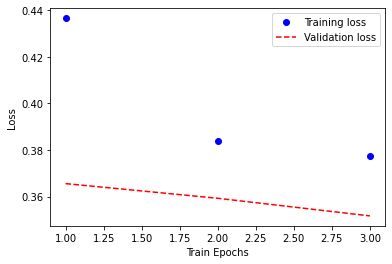

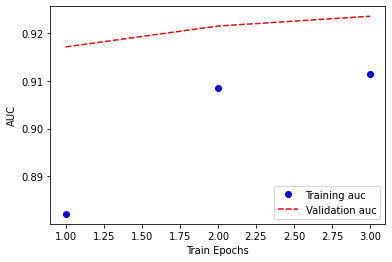

In [6]:
# inspect metrics
history_dict = history.history
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
auc = history_dict["auc"]
val_auc = history_dict["val_auc"]
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "r--", label="Validation loss")
plt.xlabel("Train Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, auc, "bo", label="Training auc")
plt.plot(epochs, val_auc, "r--", label="Validation auc")
plt.xlabel("Train Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [7]:
n = 5
s = 100

p = model.predict(x_val[:1000,:])[:, 0]

scores = eg.get_scores(x_val[:1000,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:1000,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

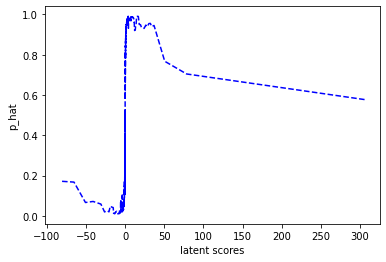

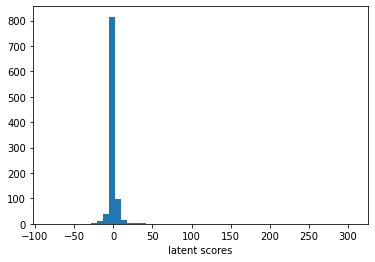

In [8]:
plt.plot(scores, p, '--b')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

plt.hist(scores, bins=50)
plt.xlabel('latent scores')
plt.show()

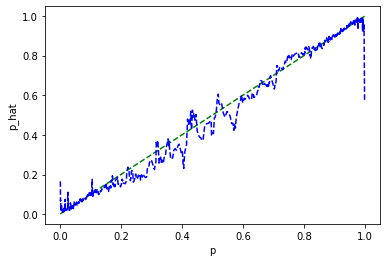

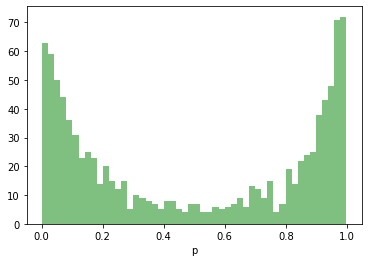

In [9]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

plt.hist(probs, bins=50, color='g', alpha=0.5)
plt.xlabel('p')
plt.show()

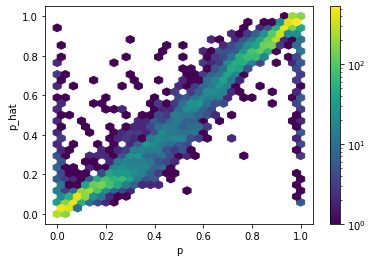

In [10]:
n = 1
s = 100

p = model.predict(x_val[:10000,:])[:, 0]

scores = eg.get_scores(x_val[:10000,:])

probs = eg.get_probabilities(x_val[:10000,:])[1]

plt.hexbin(probs, p, gridsize=30, bins='log')
plt.colorbar()
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

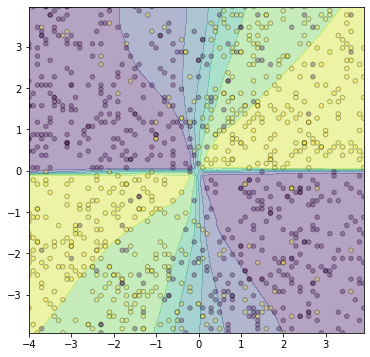

In [11]:
# Plot decision regions
I, J = 2, 6
x_min, x_max = x_val[:, I].min(), x_val[:, I].max()
y_min, y_max = x_val[:, J].min(), x_val[:, J].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
xxyy = np.c_[xx.ravel(), yy.ravel()]
x_ = 0. * np.ones((xxyy.shape[0], 10))
x_[:, I] = xxyy[:, 0]
x_[:, J] = xxyy[:, 1]
z = model.predict(x_)
z = z.reshape(xx.shape)
y_ = eg.get_labels(x_)

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.contourf(xx, yy, z, alpha=0.4)
ixs = np.random.randint(0, y_.shape[0]-1, 1000)
ax.scatter(x_[ixs, I], x_[ixs, J], c=y_[ixs], s=20, alpha=0.3, edgecolor="k")
plt.show()

#model.summary()

In [12]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 60)                660       
                                                                 
 dropout_72 (Dropout)        (None, 60)                0         
                                                                 
 dense_97 (Dense)            (None, 60)                3660      
                                                                 
 dropout_73 (Dropout)        (None, 60)                0         
                                                                 
 dense_98 (Dense)            (None, 60)                3660      
                                                                 
 dropout_74 (Dropout)        (None, 60)                0         
                                                                 
 dense_99 (Dense)            (None, 1)               

In [13]:
champion_params

{'learning_rate': 0.005600000000000001,
 'batch': 8,
 'epoch': 1,
 'optimizer': 'adamax',
 'best_loss': {'loss': 0.351462721824646, 'epoch': 3},
 'best_auc': {'auc': 0.9240903258323669, 'epoch': 3},
 'best_accuracy': {'accuracy': 0.8589000105857849, 'epoch': 3},
 'model': <keras.engine.sequential.Sequential at 0x7f0ca5317100>}

In [14]:
scan_results

[{'learning_rate': 2.4e-05,
  'batch': 256,
  'epoch': 28,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.4284617602825165, 'epoch': 41},
  'best_auc': {'auc': 0.8951289057731628, 'epoch': 41},
  'best_accuracy': {'accuracy': 0.847599983215332, 'epoch': 41}},
 {'learning_rate': 3e-05,
  'batch': 256,
  'epoch': 28,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.4055454134941101, 'epoch': 41},
  'best_auc': {'auc': 0.9053111672401428, 'epoch': 41},
  'best_accuracy': {'accuracy': 0.8546500205993652, 'epoch': 41}},
 {'learning_rate': 3.6e-05,
  'batch': 256,
  'epoch': 28,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.39470961689949036, 'epoch': 41},
  'best_auc': {'auc': 0.9115173816680908, 'epoch': 41},
  'best_accuracy': {'accuracy': 0.8530499935150146, 'epoch': 41}},
 {'learning_rate': 0.004,
  'batch': 256,
  'epoch': 59,
  'optimizer': 'sgd',
  'best_loss': {'loss': 0.40751343965530396, 'epoch': 84},
  'best_auc': {'auc': 0.9027903079986572, 'epoch': 84},
  'best_accuracy

### Tuning notes: 

Data: train 100096 / val 20000

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 80/80 **val_loss: 0.4221** - val_accuracy: 0.7657 - val_auc: 0.9857

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 60/80 **val_loss: 0.3241** - val_accuracy: 0.8463 - val_auc: 0.9856

--
* model: 40, 0.25, 40, 0.25, 40, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 40/80 **val_loss: 0.2726** - val_accuracy: 0.8848 - val_auc: 0.9889

--
* model: 50, 0.25, 50, 0.25, 50, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 38/80 **val_loss: 0.2555** - val_accuracy: 0.8832 - val_auc: 0.9916

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 28/80 **val_loss: 0.2552** - val_accuracy: 0.8909 - val_auc: 0.9929

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 48/80 **0.2557** - val_accuracy: 0.8771 - val_auc: 0.9935

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 20, 0.25, 6, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 47/80 **0.3482** - val_accuracy: 0.8346 - val_auc: 0.9910

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 5e-3
* Epoch: 59/80 **0.2176** - val_accuracy: 0.8953 - val_auc: 0.9961

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 3e-3
* Epoch: 80/100 **0.2205** - val_accuracy: 0.8970 - val_auc: 0.9951

--
8/1e-2=> 0.2021 - val_accuracy: 0.9207 - val_auc: 0.9904
8/8e-3=> 0.26...
8/1.3e-2=> 0.25